In [21]:
from datasets import load_dataset
import os
import torch
import torch.optim as optim
from utils.hybrid_model import *
from utils.hybrid_utils import *
from utils.utils import *

# Data preparation

In [22]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [23]:
# Obtain a list of unique words from the train set
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# Pass it in to the load_word2vec function along w the relative filepath of the embedding file
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [24]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

Dataloaders

In [25]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [26]:
BATCH_SIZE = 32

trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# Model

In [27]:
model = CNNRNNHybridModel(
    embed_dim=350,  # Embedding dimension, matching Word2vec or GloVe
    rnn_hidden_dim=128,
    num_classes= 1, # Binary classification
    kernel_size= 3, # Size of the kernel for the CNN layer
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    embedding_matrix=word2vec_model.vectors,
)

## Hybrid Model with Default RNN
Default RNN - Part 3.1 Accuracy: 0.7355, Part 3.2 Accuracy: 0.7514

In [28]:
# Train and validate the model
train_losses, val_accuracies = train_hybrid_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    criterion=nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    train_mode= None
)


Epoch 1/100, Loss: 0.6933
Accuracy: 0.5000
Model saved.
Epoch 2/100, Loss: 0.6916
Accuracy: 0.5272
Model saved.
Epoch 3/100, Loss: 0.6768
Accuracy: 0.6023
Model saved.
Epoch 4/100, Loss: 0.5797
Accuracy: 0.6801
Model saved.
Epoch 5/100, Loss: 0.4435
Accuracy: 0.7036
Model saved.
Epoch 6/100, Loss: 0.3374
Accuracy: 0.7045
Model saved.
Epoch 7/100, Loss: 0.2639
Accuracy: 0.7017
Epoch 8/100, Loss: 0.2106
Accuracy: 0.6979
Epoch 9/100, Loss: 0.1607
Accuracy: 0.6932
Epoch 10/100, Loss: 0.1246
Accuracy: 0.6857
Epoch 11/100, Loss: 0.1023
Accuracy: 0.6829
Epoch 12/100, Loss: 0.0770
Accuracy: 0.6979
Epoch 13/100, Loss: 0.0618
Accuracy: 0.6904
Epoch 14/100, Loss: 0.0525
Accuracy: 0.6942
Epoch 15/100, Loss: 0.0452
Accuracy: 0.6867
Epoch 16/100, Loss: 0.0322
Accuracy: 0.6820
Early stopping triggered.
Loading the best model from saved checkpoint...
Model loaded.


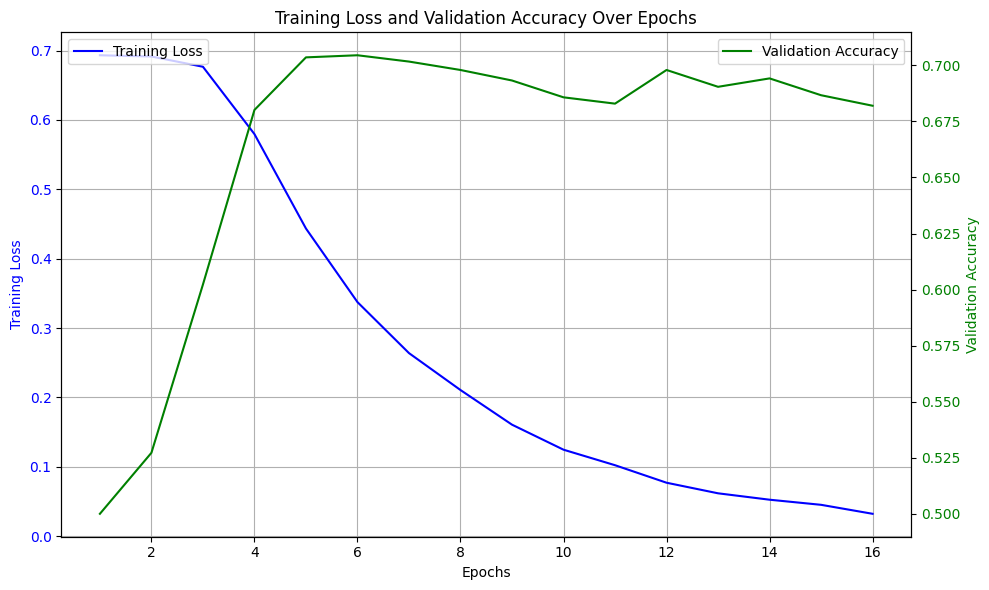

In [29]:
plot_training_progress(train_losses, val_accuracies)

In [30]:
default_rnn_test_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7317


In [31]:
print(f"Test accuracy: {default_rnn_test_accuracy:.4f}")

Test accuracy: 0.7317


## Hybrid Model with Last State
Last State - Part 3.1 Accuracy: 0.7186, Part 3.2 Accuracy: 0.7514

In [32]:
# Train and validate the model
train_losses, val_accuracies = train_hybrid_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    criterion=nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    train_mode= "last_state"
)


Epoch 1/100, Loss: 0.2635
Accuracy: 0.7017
Model saved.
Epoch 2/100, Loss: 0.2174
Accuracy: 0.6961
Epoch 3/100, Loss: 0.1802
Accuracy: 0.7026
Model saved.
Epoch 4/100, Loss: 0.1466
Accuracy: 0.7054
Model saved.
Epoch 5/100, Loss: 0.1166
Accuracy: 0.6970
Epoch 6/100, Loss: 0.0946
Accuracy: 0.6989
Epoch 7/100, Loss: 0.0772
Accuracy: 0.6923
Epoch 8/100, Loss: 0.0650
Accuracy: 0.6989
Epoch 9/100, Loss: 0.0539
Accuracy: 0.6932
Epoch 10/100, Loss: 0.0416
Accuracy: 0.6979
Epoch 11/100, Loss: 0.0374
Accuracy: 0.6895
Epoch 12/100, Loss: 0.0283
Accuracy: 0.6951
Epoch 13/100, Loss: 0.0263
Accuracy: 0.6989
Epoch 14/100, Loss: 0.0214
Accuracy: 0.6951
Early stopping triggered.
Loading the best model from saved checkpoint...
Model loaded.


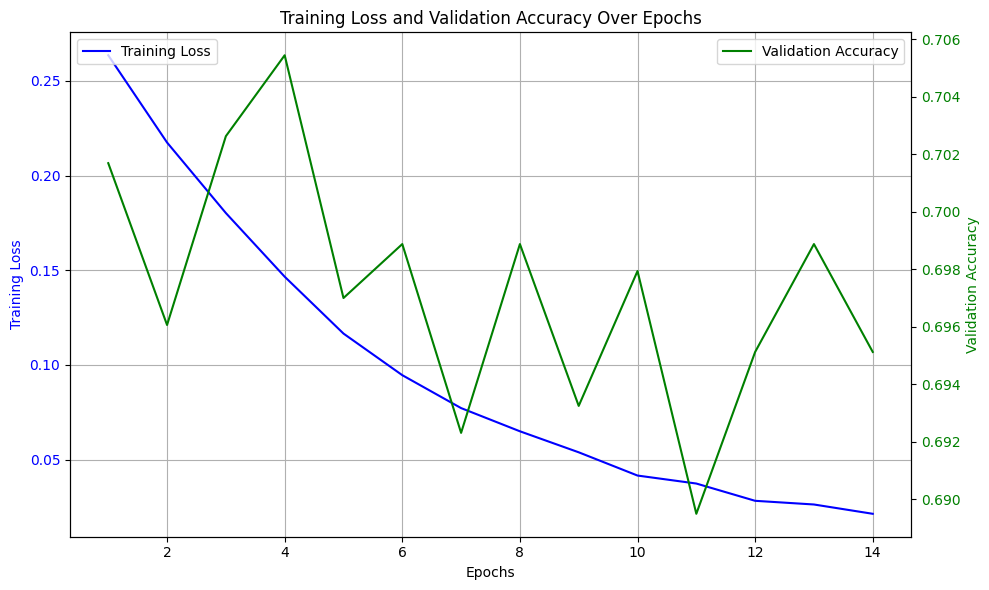

In [33]:
plot_training_progress(train_losses, val_accuracies)

In [34]:
last_state_test_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7392


In [35]:
print(f"Test accuracy: {last_state_test_accuracy:.4f}")

Test accuracy: 0.7392


## Hybrid Model with Max Pooling

Max Pooling - Part 3.1 Accuracy: 0.7298, Part 3.2 Accuracy: 0.7505

In [36]:
# Train and validate the model
train_losses, val_accuracies = train_hybrid_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    criterion=nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    train_mode= "max_pool"
)


Epoch 1/100, Loss: 0.1209
Accuracy: 0.7008
Model saved.
Epoch 2/100, Loss: 0.0931
Accuracy: 0.6942
Epoch 3/100, Loss: 0.0784
Accuracy: 0.6979
Epoch 4/100, Loss: 0.0595
Accuracy: 0.7045
Model saved.
Epoch 5/100, Loss: 0.0526
Accuracy: 0.6998
Epoch 6/100, Loss: 0.0451
Accuracy: 0.6904
Epoch 7/100, Loss: 0.0366
Accuracy: 0.6923
Epoch 8/100, Loss: 0.0320
Accuracy: 0.6886
Epoch 9/100, Loss: 0.0279
Accuracy: 0.6961
Epoch 10/100, Loss: 0.0218
Accuracy: 0.6839
Epoch 11/100, Loss: 0.0199
Accuracy: 0.6914
Epoch 12/100, Loss: 0.0174
Accuracy: 0.6829
Epoch 13/100, Loss: 0.0152
Accuracy: 0.6923
Epoch 14/100, Loss: 0.0133
Accuracy: 0.6876
Early stopping triggered.
Loading the best model from saved checkpoint...
Model loaded.


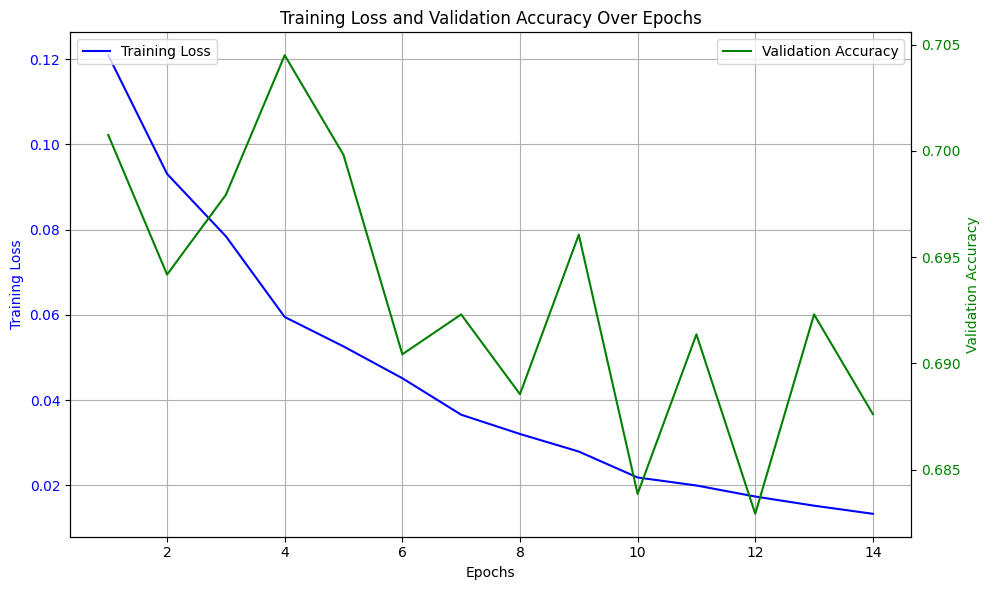

In [37]:
plot_training_progress(train_losses, val_accuracies)

In [38]:
max_pool_test_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7373


In [39]:
print(f"Test accuracy: {max_pool_test_accuracy:.4f}")

Test accuracy: 0.7373


# Results

In [40]:
print(f"Hybrid model with Default RNN Test Accuracy:      {default_rnn_test_accuracy:.4f}")
print(f"Hybrid model with Last State Test Accuracy:       {last_state_test_accuracy:.4f}")
print(f"Hybrid model with Max Pool Test Accuracy:         {max_pool_test_accuracy:.4f}")

Hybrid model with Default RNN Test Accuracy:      0.7317
Hybrid model with Last State Test Accuracy:       0.7392
Hybrid model with Max Pool Test Accuracy:         0.7373
